In [1]:
from sbi.utils import BoxUniform
import torch
from sbi.inference import SNPE
from sbi.analysis import pairplot
import matplotlib.pyplot as plt
from torch import ones
import matplotlib as mpl
import pickle
from sbi.utils.support_posterior import PosteriorSupport

### Define problem

In [2]:
def my_sim(theta):
    return theta**2 + torch.randn(theta.shape)*0.2

In [3]:
p1 = BoxUniform(-2*ones(1), -1*ones(1))
p2 = BoxUniform(ones(1), 2*ones(1))

In [4]:
class SharedPrior(BoxUniform):
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def sample(self, num_samples):
        s = num_samples[0] / 2
        s1 = self.p1.sample((int(s),))
        s2 = self.p2.sample((int(s),))
        cated = torch.cat([s1, s2])
        r = torch.randperm(cated.size()[0])
        return cated[r]
    def log_prob(self, theta):
        p1 = torch.exp(self.p1.log_prob(theta))
        p2 = torch.exp(self.p2.log_prob(theta))
        return torch.log(0.5 * p1 + 0.5 * p2)

In [5]:
prior = SharedPrior(p1, p2)

In [6]:
grid_low = -2.5
grid_high = 2.5
def eval_likelihood(theta, x):
    mean = theta**2
    dist = torch.distributions.Normal(mean, 0.2)
    return dist.log_prob(x)
def eval_prior(theta):
    return prior.log_prob(theta.unsqueeze(1))

In [7]:
xo = torch.tensor([1.2])
resolution = 500
def posterior_eval(theta):
    ll = eval_likelihood(theta, xo)
    pl = eval_prior(theta)
    joint = ll + pl
    joint_exp = torch.exp(joint)
    integral = torch.sum(joint_exp) / resolution * (grid_high - grid_low)
    posterior = joint_exp / integral
    return posterior

In [8]:
theta_range = torch.linspace(grid_low, grid_high, resolution)

In [9]:
post = posterior_eval(theta_range)

In [10]:
prior_probs = eval_prior(theta_range)

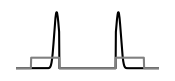

In [12]:
with mpl.rc_context(fname="../../../paper/.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 0.8))
    _ = ax.plot(theta_range.numpy(), post.numpy(), c="k")
    _ = ax.plot(theta_range.numpy(), torch.exp(prior_probs).numpy(), c="gray")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    plt.savefig("../svg/panel_a.svg")

### Run APT

In [13]:
_ = torch.manual_seed(0)
inference = SNPE(prior, density_estimator="nsf")
proposal = prior
posteriors = []
for r in range(10):

    theta = proposal.sample((500,))
    x = my_sim(theta)

    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(torch.tensor([[1.2]]))
    proposal = posterior
    
    if r == 4 or r == 9:
        posteriors.append(posterior)

In [13]:
net_apt = posteriors[0].posterior_estimator

In [14]:
apt_probs = net_apt.log_prob(theta_range.unsqueeze(1), context=torch.tensor([[1.2]]).repeat((resolution,1)))

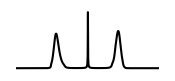

In [15]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 0.8))
    _ = ax.plot(theta_range.numpy(), torch.exp(apt_probs.detach()).numpy(), c="k")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    plt.savefig("../svg/panel_b1.svg")

In [16]:
net_apt = posteriors[1].posterior_estimator

In [17]:
apt_probs = net_apt.log_prob(theta_range.unsqueeze(1), context=torch.tensor([[1.2]]).repeat((resolution,1)))

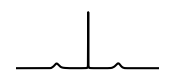

In [18]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 0.8))
    _ = ax.plot(theta_range.numpy(), torch.exp(apt_probs.detach()).numpy(), c="k")
    # _ = ax.plot(theta_range.numpy(), torch.exp(prior_probs).numpy())
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    plt.savefig("../svg/panel_b2.svg")

### Run TSNPE

In [19]:
_ = torch.manual_seed(1)
inference = SNPE(prior, density_estimator="nsf")
proposal = prior
for _ in range(5):

    theta = proposal.sample((500,))
    x = my_sim(theta)

    _ = inference.append_simulations(theta, x).train(force_first_round_loss=True)
    posterior = inference.build_posterior().set_default_x(torch.tensor([[1.2]]))
    proposal = PosteriorSupport(prior=prior, posterior=posterior, allowed_false_negatives=0.0001)
    net_tsnpe = posterior.posterior_estimator

 Neural network successfully converged after 116 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

The classifier rejected 19.8000% of all samples. You will get a speed-up of 24.7%.
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

The classifier rejected 63.0200% of all samples. You will get a speed-up of 170.4%.
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

The classifier rejected 64.4500% of all samples. You will get a speed-up of 181.3%.
 Neural network successfully converged after 80 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

The classifier rejected 53.8800% of all samples. You will get a speed-up of 116.8%.
 Neural network successfully converged after 30 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
net_tsnpe = posterior.posterior_estimator

In [21]:
tsnpe_probs = net_tsnpe.log_prob(theta_range.unsqueeze(1), context=torch.tensor([[1.2]]).repeat((resolution,1)))

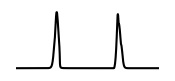

In [22]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 0.8))
    _ = ax.plot(theta_range.numpy(), torch.exp(tsnpe_probs.detach()).numpy(), c="k")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    plt.savefig("../svg/panel_c.svg")

# Assemble figure

In [14]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [23]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

width = 15
f = Figure(f"{width}cm", "1.8cm",

    Panel(
          SVG("../svg/panel_a.svg").scale(svg_scale).move(0, 0),
          Text("Ground", 11, 12.0, **kwargs_text8pt),
        Text("truth", 11, 26.0, **kwargs_text8pt),
    ).move(-10, 0),
    Panel(
          SVG("../svg/panel_b1.svg").scale(svg_scale).move(0, 0),
          Text("APT", 11, 12.0, **kwargs_text8pt),
    ).move(150, 0),
    Panel(
          SVG("../svg/panel_c.svg").scale(svg_scale).move(0, 0),
          Text("TSNPE", 11, 12.0, **kwargs_text8pt),
    ).move(310, 0),
)

f.save("../fig/fig6.svg")
svg('../fig/fig6.svg')

In [25]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

width = 15.7 * 0.23
f = Figure(f"15.7cm", "1.8cm",
    Panel(
          SVG("../svg/panel_b2.svg").scale(svg_scale).move(0, 0),
          Text("APT", 11, 12.0, **kwargs_text8pt),
          Text("10 rounds", 11, 22.0, **kwargs_text8pt),
    ).move(-10, 0),

)

f.save("../fig/fig6_20rounds.svg")
svg('../fig/fig6_20rounds.svg')